### Introduction
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

### The process
- We pick the number of topics ahead of time even if we’re not sure what the topics are.
- Each document is represented as a distribution over topics.
- Each topic is represented as a distribution over words.

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

#### Loading data


Let’s start by looking at the content of the file

In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Importing modules
%load_ext autotime

# Importar librerias
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', True)
import os

#Importar los datasets
url_reddit = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/RedditNews.csv'
url_combined = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/Combined_News_DJIA.csv'
RedditNews = pd.read_csv(url_reddit)
CombinedNews = pd.read_csv(url_combined)


RedditNews['Date'] =  pd.to_datetime(RedditNews['Date'], format='%Y-%m-%d')
CombinedNews['Date'] =  pd.to_datetime(CombinedNews['Date'], format='%Y-%m-%d')


In [3]:
## Nos quedamos con las fechas del dataset que está etiquetado
RedditNews = RedditNews[RedditNews['Date'].isin(CombinedNews['Date'])]

display(
    CombinedNews['Date'].nunique(),
    RedditNews['Date'].nunique() )

1989

1989

time: 28 ms


In [4]:
1989*25

49725

time: 143 ms


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [5]:
## Hay error en la codificación de caracteres especiales, encontré ese, pero hay que ver que otros surgen
RedditNews['News'] = RedditNews['News'].str.replace("year.old", " year old ", regex=True)
RedditNews['News'] = RedditNews['News'].str.replace("\d year", " year ", regex=True)
RedditNews['News'] = RedditNews['News'].str.replace("year old", "years old", regex=True)


RedditNews['News'] = RedditNews['News'].str.replace("years.old", " years old ", regex=True)
RedditNews['News'] = RedditNews['News'].str.replace("\d years", " years ", regex=True)

time: 552 ms


In [6]:
## Hay error en la codificación de caracteres especiales, encontré ese, pero hay que ver que otros surgen
index_review = RedditNews[(RedditNews['News'].str.startswith('b"')) |
                         (RedditNews['News'].str.startswith("b'"))].index

display(RedditNews[RedditNews['News'].str.startswith('b"')].head(),
        RedditNews[RedditNews['News'].str.startswith("b'")].head())


RedditNews['News'] = RedditNews['News'].str.replace('^b\"', " ", regex=True)
RedditNews['News'] = RedditNews['News'].str.replace("^b\'", " ", regex=True)

,Date,News
54798,2010-06-30,"b""South Korea's parliament votes to legalize c..."
54804,2010-06-30,"b""The German economy is rapidly improving, wit..."
54819,2010-06-30,"b""BBC News - Russian spy suspect missing in Cy..."
54821,2010-06-30,"b""Iraq inquiry: secret documents showing Tony ..."
54822,2010-06-30,"b""Apartheid loves apartheid: Israel's secret r..."


,Date,News
54799,2010-06-30,b'Pope rebukes cardinal who exposed abuse: \nP...
54800,2010-06-30,b'This depression is similar to the Great Pani...
54801,2010-06-30,b'The Niger Delta has experienced oil spills o...
54802,2010-06-30,b'G20 Toronto - So Black Block get green light...
54803,2010-06-30,b'Half of Afghanistans 476 women prisoners wer...


time: 449 ms


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [7]:
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words("english")
REPLACE_BY_SPACE_RE = re.compile('[(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ^#\+_]')
SEP_NUMBER = re.compile('(?<=\d)\,|\.(?=\d)')
USA_ABREV = re.compile('U\.S|u\.s\|u\.s\.a\.|US')
DOT_ABREV = re.compile('\.(?![a-zA-Z]{2})')
STARTING_B = re.compile("^\"b' |^b ")
STOPWORDS = stopwords.words('english')

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    
    text = USA_ABREV.sub(' usa ', text) # replace U.S U.S. u.s US for usa
    text = text.lower() # lowercase text
    text = text.replace("al-qaeda", "alqaeda")
    text = text.replace("al-qa'eda", "alqaeda")
    text = text.replace('&amp;', '&')
    text = text.replace('&', '')    

    text = DOT_ABREV.sub('', text) # removes abrevetion dot, ej: L.G.B.T  = LGBT
    text = SEP_NUMBER.sub('', text) # removes . and , seprating numbers
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = STARTING_B.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = text.strip()
    return text
    
RedditNews['News'] = RedditNews['News'].apply(clean_text)

time: 5.75 s


#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

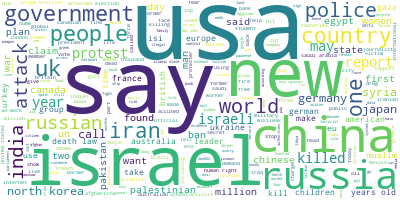

time: 8.81 s


In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(RedditNews['News'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

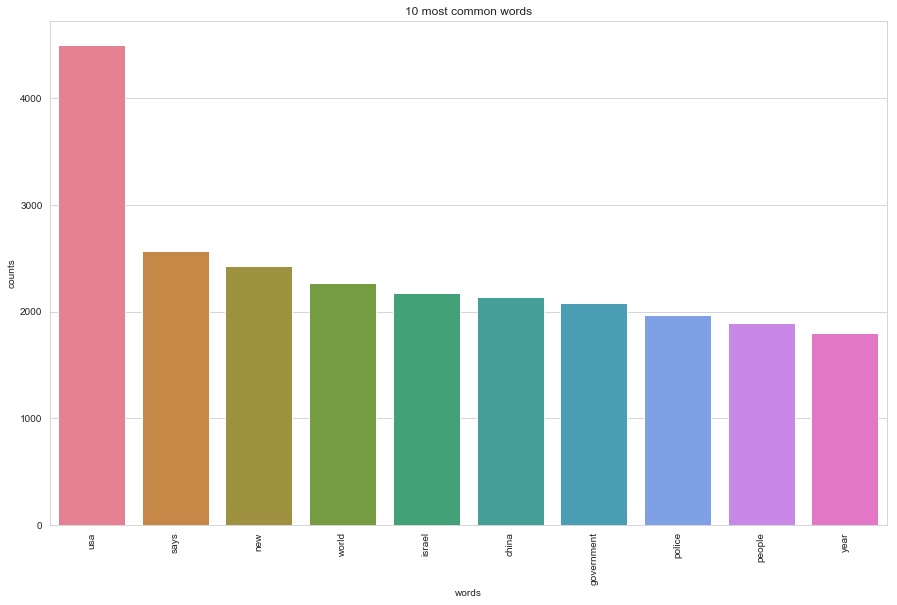

time: 8.23 s


In [9]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(RedditNews['News'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [10]:
# !pip install gensim
# !pip install PyLDAvis
# !pip install spacy
# !python -m spacy download en_core_web_sm

time: 1 ms


#### Tokenize words and further clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [11]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = RedditNews.News.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['years', 'old', 'woman', 'mexico', 'city', 'finally', 'received', 'birth', 'certificate', 'died', 'hours', 'later', 'trinidad', 'alvarez', 'lira', 'waited', 'years', 'proof', 'born']
time: 3.59 s


#### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

time: 17.7 s


#### Remove Stopwords, Make Bigrams and Lemmatize
The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [13]:
# NLTK Stop words
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

time: 3 ms


In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


time: 984 ms


In [16]:

# Convert to tokens
data = RedditNews.News.values.tolist()

def prepare_text_for_lda(text):
    data_words = list(sent_to_words(text))

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)


    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

data_lemmatized = prepare_text_for_lda(data)

print(data_lemmatized[:1][0][:30])

['years_old', 'woman', 'mexico', 'city', 'finally', 'receive', 'birth', 'certificate', 'die', 'hour', 'later', 'trinidad', 'alvarez', 'lira', 'wait', 'year', 'proof', 'bear']
time: 3min 38s


### Data transformation: Corpus and Dictionary
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.
First, we are creating a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(len(id2word))
id2word.filter_extremes(no_below=5, no_above=0.5)
print(len(id2word))


# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

26176
9079
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]
time: 2.11 s


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bear', 1),
  ('birth', 1),
  ('certificate', 1),
  ('city', 1),
  ('die', 1),
  ('finally', 1),
  ('hour', 1),
  ('later', 1),
  ('mexico', 1),
  ('proof', 1),
  ('receive', 1),
  ('wait', 1),
  ('woman', 1),
  ('year', 1),
  ('years_old', 1)]]

time: 9 ms


In [19]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
id2word.save('dictionary.gensim')

time: 365 ms


### Building the base topic model
We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [27]:
NUM_TOPICS = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=NUM_TOPICS, 
                                       random_state=100,
                                       chunksize=2000,
                                       passes=15,
                                       per_word_topics=True,
                                      workers = 4)

lda_model.save('model5.gensim')

time: 3min 20s


In [21]:
print("Topics found via LDA:")

from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

Topics found via LDA:
[(0,
  '0.018*"police" + 0.015*"kill" + 0.012*"man" + 0.011*"woman" + '
  '0.011*"protest" + 0.009*"arrest" + 0.009*"people" + 0.008*"death" + '
  '0.008*"attack" + 0.007*"year"'),
 (1,
  '0.011*"government" + 0.011*"law" + 0.010*"say" + 0.008*"ban" + '
  '0.007*"right" + 0.007*"country" + 0.006*"drug" + 0.006*"new" + '
  '0.006*"internet" + 0.006*"child"'),
 (2,
  '0.038*"usa" + 0.015*"say" + 0.015*"russia" + 0.014*"israel" + '
  '0.014*"israeli" + 0.012*"russian" + 0.010*"war" + 0.010*"military" + '
  '0.010*"iran" + 0.009*"palestinian"'),
 (3,
  '0.019*"find" + 0.008*"die" + 0.006*"bank" + 0.006*"dead" + 0.005*"worker" + '
  '0.005*"city" + 0.004*"year" + 0.004*"get" + 0.004*"pay" + 0.004*"say"'),
 (4,
  '0.016*"china" + 0.016*"world" + 0.010*"year" + 0.009*"nuclear" + '
  '0.008*"new" + 0.008*"country" + 0.007*"say" + 0.007*"oil" + '
  '0.007*"north_korea" + 0.005*"usa"')]
time: 113 ms


###  Finding the dominant topic in each sentence

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)


time: 4min 17s


In [23]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8371,"find, die, bank, dead, worker, city, year, get...",117 years old woman mexico city finally receiv...
1,1,3.0,0.4060,"find, die, bank, dead, worker, city, year, get...",imf chief backs athens permanent olympic host
2,2,1.0,0.5108,"government, law, say, ban, right, country, dru...",president france says brexit donald trump
3,3,0.0,0.5948,"police, kill, man, woman, protest, arrest, peo...",british man must give police 24 hours notice s...
4,4,2.0,0.5326,"usa, say, russia, israel, israeli, russian, wa...",100+ nobel laureates urge greenpeace stop oppo...
5,5,0.0,0.6229,"police, kill, man, woman, protest, arrest, peo...",brazil huge spike number police killings rio a...
6,6,1.0,0.7476,"government, law, say, ban, right, country, dru...",austria highest court annuls presidential elec...
7,7,1.0,0.5910,"government, law, say, ban, right, country, dru...",facebook wins privacy case track belgian wants...
8,8,1.0,0.6999,"government, law, say, ban, right, country, dru...",switzerland denies muslim girls citizenship re...
9,9,4.0,0.3920,"china, world, year, nuclear, new, country, say...",china kills millions innocent meditators organ...


time: 38 ms


### Find the most representative document for each topic

In [24]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9696,"police, kill, man, woman, protest, arrest, peo...",iran president criticized use thousands underc...
1,1.0,0.9700,"government, law, say, ban, right, country, dru...",france passes sweeping gender equality law tim...
2,2.0,0.9710,"usa, say, russia, israel, israeli, russian, wa...",germany nixes surveillance pact usa britain ge...
3,3.0,0.9692,"find, die, bank, dead, worker, city, year, get...",astronomers announced today spotted large rock...
4,4.0,0.9729,"china, world, year, nuclear, new, country, say...",china plan cap co2 emissions seen turning poin...


time: 144 ms


### What is Topic Coherence?
Perplexity is often used as an example of an intrinsic evaluation measure. It comes from the language modeling community and aims to capture how surprised a model is of new data it has not seen before. It is measured as the normalized log-likelihood of a held-out test set.

Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

However, past research has shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. And that served as a motivation for more work trying to model the human judgment, and thus Topic Coherence.

The topic coherence concept combines a number of papers into one framework that allows evaluating the coherence of topics inferred by a topic model. But,

#### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But,

#### What is coherence?
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is "the game is a team sport", "the game is played with a ball", "the game demands great physical efforts"

### Coherence Measures
- C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
- C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson's coherence
- C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
- C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
- C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
- C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

#### Compute Model Perplexity and Coherence Score
Let's calculate the baseline coherence score

In [25]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.27658527359234314
time: 6.88 s


### Hyperparameter tuning
First, let's differentiate between model hyperparameters and model parameters :

- Model hyperparameters can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K
- Model parameters can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters:

- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density
We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use C_v as our choice of metric for performance comparison

In [28]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=2000,
                                           passes=15,
                                           alpha=a,
                                           eta=b,
                                          workers = 4)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

time: 997 µs


Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values


In [29]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 4
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results2.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████| 240/240 [13:58:24<00:00, 212.28s/it]


time: 13h 58min 24s


### Final Model Training
Based on external evaluation (Code to be added from Excel based analysis), train the final model



In [59]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           chunksize=2000,
                                           passes=15,
                                           alpha='symmetric',
                                           eta=0.61)

time: 4min 34s


In [60]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"police" + 0.022*"protest" + 0.013*"arrest" + 0.011*"protester" + '
  '0.009*"government" + 0.009*"people" + 0.007*"london" + 0.007*"officer" + '
  '0.006*"thousand" + 0.006*"french"'),
 (1,
  '0.016*"law" + 0.015*"drug" + 0.010*"say" + 0.010*"canada" + 0.009*"new" + '
  '0.009*"right" + 0.008*"become" + 0.008*"country" + 0.007*"government" + '
  '0.007*"war"'),
 (2,
  '0.026*"usa" + 0.019*"israel" + 0.016*"say" + 0.014*"iran" + '
  '0.008*"military" + 0.008*"russia" + 0.008*"call" + 0.008*"state" + '
  '0.007*"syria" + 0.007*"secret"'),
 (3,
  '0.032*"find" + 0.010*"die" + 0.006*"man" + 0.006*"world" + 0.006*"year" + '
  '0.006*"years_old" + 0.006*"old" + 0.005*"dead" + 0.005*"body" + '
  '0.005*"discover"'),
 (4,
  '0.016*"world" + 0.016*"nuclear" + 0.015*"year" + 0.007*"bad" + 0.007*"say" '
  '+ 0.007*"country" + 0.006*"crisis" + 0.006*"new" + 0.006*"water" + '
  '0.006*"could"'),
 (5,
  '0.026*"usa" + 0.015*"israeli" + 0.013*"say" + 0.012*"president" + '
  '0.012*"pal

In [61]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis


LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

pyLDAvis.display(LDAvis_prepared)

time: 7min 21s


In [62]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(11))+'.pkl'

with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)

time: 78.1 ms


In [63]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(11) +'.html')

time: 69 ms


### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this post addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### Sources:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf


https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0